# Impact Classifier

The project proposes to leverage machine learning (ML) and natural language processing (NLP) techniques to build a text classifier that automatizes the processing and identification of evidence of social impact in research documents. The proposal aims to solve a classification problem in which the model takes a sentence contained in a research document as input and produces as output a binary answer (1=True, 0=False) that states whether the sentence contains or not evidence of social impact, respectively.

From all research fields, this project focuses on Medical, Health, and Biological science because the ultimately goal is to understand the social impact of the research projects of the Spanish National Institue of Bioinformatics (INB by its Spanish Acronym), which is an institution that conducts medical and biological investigations.

The goal in this notebook is to develop a machine learning classifier able to automatically identify sentences of social impact in research documents.

## Load libraries

In [214]:
# import libraries
import numpy as np
import nltk
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import sys
import joblib
import pickle


nltk.download("stopwords")
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from bs4 import BeautifulSoup
from xgboost import XGBClassifier
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm import tqdm

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/Life/jsaldiva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/Life/jsaldiva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load data

### Impact sentences

Load dataset that sentences with evidence of social impact. The dataset was manually built through a process that is explain in the notebook **`0.dataset_preparation.ipynb`**.

In [2]:
impact_sentences = pd.read_csv("data/sentences/impact_sentences.csv", usecols=['sentence'])

#### Add label column

Sentences with evidence of social will later be merged with more general sentences that can be commonly found in research documents. By the time the merge occurs, social impact sentences need to be distinguised from the more general sentences. Therefore, a the new column **`label`** is created in the impact dataset to tag with 1 all sentences that contain evidence of social impact.  

In [3]:
impact_sentences['label'] = 1

In [13]:
nrows = impact_sentences.shape[0]
ncols = impact_sentences.shape[1]
print(f"The dataset contains {nrows} rows and {ncols} columns")

The dataset contains 206 rows and 2 columns


Let's show an sample of impact sentences together with the newly created column label.

In [5]:
impact_sentences.head()

,sentence,label
0,widely featured in the national press and rad...,1
1,indeed one of these projects has been select...,1
2,impact public engagement and education influen...,1
3,reach worldwide dolly became a scientific icon...,1
4,the educational tools have been used by 11 000...,1


### General sentences

Load dataset containing sentences that are commonly found in medical and bioinformatics research documents. The process followed to build the dataset of general sentences is described in the notebook **`0.dataset_preparation.ipynb`**.

In [6]:
gral_sentences = pd.read_csv("data/sentences/gral_sentences.csv", index_col=0)

#### Add label column

As in the case of the dataset of impact sentences, here a column **`label`** is also created to tag with 0 all general sentences.

In [7]:
gral_sentences['label'] = 0

In [14]:
nrows = gral_sentences.shape[0]
ncols = gral_sentences.shape[1]
print(f"The dataset contains {nrows} rows and {ncols} columns")

The dataset contains 800 rows and 2 columns


Let's show a sample of the dateset

In [15]:
gral_sentences.head()

,sentence,label
0,notably lncrnas are known to coordinate aggres...,0
1,given these complexities a general framework f...,0
2,it has been proposed that tumors with similar ...,0
3,we also excluded an additional patient for who...,0
4,although our report does not address the expre...,0


### Merge datasets

Merge both datasets, the general and impact one.

In [62]:
total_sentences = pd.concat([impact_sentences, gral_sentences], ignore_index=True)

In [63]:
nrows = total_sentences.shape[0]
ncols = total_sentences.shape[1]
print(f"The combined dataset contains {nrows} rows and {ncols} columns")

The combined dataset contains 1006 rows and 2 columns


## Explore data

Next, the dataset is explored by, first, computing the most frequent terms in sentences that contain evidence of social impact and, then, by calculating the most frequent term in general sentences.

In [18]:
word_black_list = ['research', 'impact', 'uk']  # let's add context specify words that will be filtered before computing frequencies
max_items_to_show = 30

### Most frequent terms in social impact sentences

Inspect the most used terms used in sentences that express evidence of social impact

In [19]:
si_sentences = total_sentences[total_sentences['label']==1]['sentence']
si_words = []
for si_sentence in si_sentences:
    for word in si_sentence.split():
        if len(word) > 2 and word not in word_black_list and word not in stopwords.words('english'):
            si_words.append(word)
fdist = FreqDist(si_words)
freq_words_df = pd.DataFrame(fdist.items(), columns=['word', 'frequency'])

In [26]:
freq_words_df.sort_values(by='frequency', ascending=False, inplace=True)

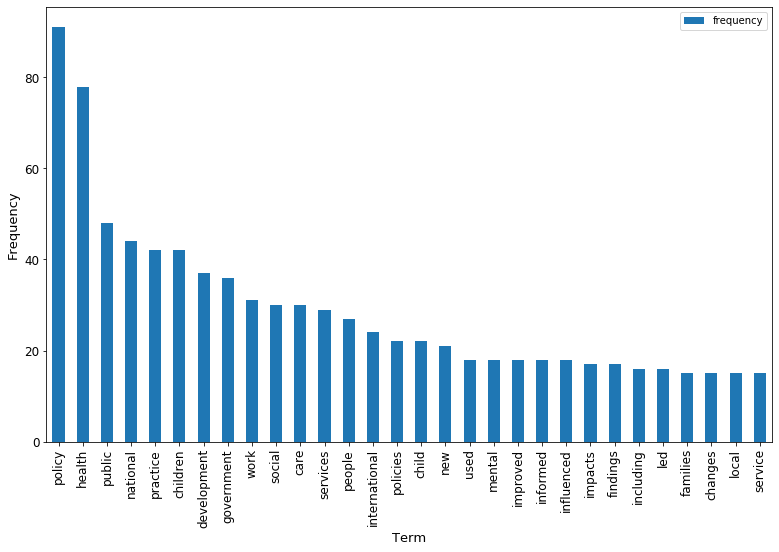

In [35]:
freq_words_df.iloc[0:max_items_to_show,:].plot(x='word', y='frequency', kind='bar', figsize=(13,8))
plt.xticks(rotation=90)
plt.xlabel("Term", size=13)
plt.ylabel("Frequency", size=13)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

### Most frequent terms in general sentences

Inspect the most used terms in sentences that do not neccesarily contain evidence of social impact

In [32]:
n_si_sentences = total_sentences[total_sentences['label']==0]['sentence']
n_fdist = FreqDist(word for n_si_sentence in n_si_sentences 
                        for word in n_si_sentence.split() if len(word) > 2 and word not in stopwords.words('english') and word not in word_black_list)
n_freq_words_df = pd.DataFrame(n_fdist.items(), columns=['word', 'frequency'])

In [33]:
n_freq_words_df.sort_values(by='frequency', ascending=False, inplace=True)

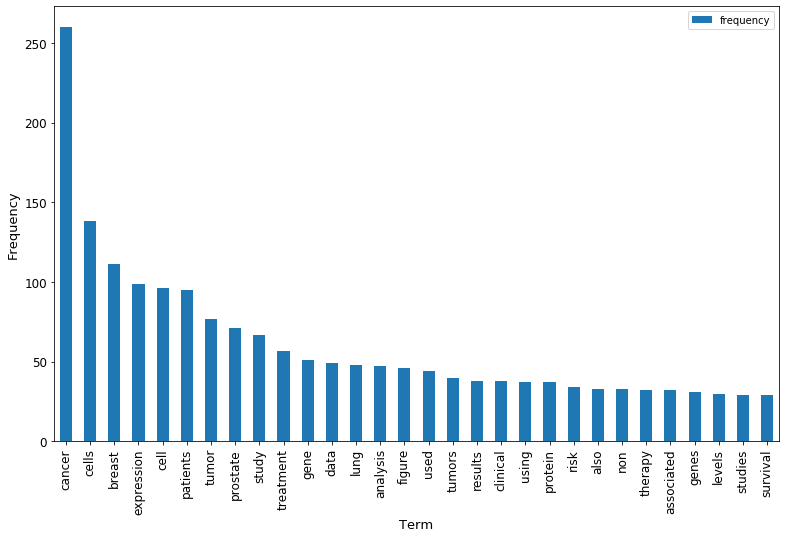

In [36]:
n_freq_words_df.iloc[0:max_items_to_show,:].plot(x='word', y='frequency', kind='bar', figsize=(13,8))
plt.xticks(rotation=90)
plt.xlabel("Term", size=13)
plt.ylabel("Frequency", size=13)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

From the figures above it can be seen there is little overlap between the most frequent terms in sentences with evidence of social impact (e.g., public policy, health, national, development) and the most frequent terms in the general sentences, which, as expected, are more related with medical and biological terminologies, such as cancer, cells, patients, tumor, or therapy. The low interception between the most frequent terms in the two datasets demonstrates the potential of the data to train machine learning classifier. 

## Save validation data

Take from the dataset a random sample that is going to be used later in the validation phase

In [64]:
random_state = np.random.RandomState(1234)  # set a random seed for reproducibility purposes
validation_impact_sentences = total_sentences[total_sentences['label']==1].sample(frac=0.2, random_state=random_state)
validation_gral_sentences = total_sentences[total_sentences['label']==0].sample(frac=0.2, random_state=random_state)
validation_sentences = pd.concat([validation_impact_sentences, validation_gral_sentences], ignore_index=True)
nrows_impact, _ = validation_sentences[test_sentences['label']==1].shape
nrows_gral, _ = validation_sentences[test_sentences['label']==0].shape
print(f"The test set contains {nrows_impact} rows with social impact sentences and {nrows_gral} rows with general sentences")

The test set contains 41 rows with social impact sentences and 160 rows with general sentences


Let's save the test dataset to use it in the testing phase

In [65]:
validation_sentences.to_csv('./data/validation_data.csv', index=False)

Remove from dataset rows selected for validation

In [66]:
validation_indexes = list(validation_impact_sentences.index) + list(validation_gral_sentences.index)
total_sentences = total_sentences[~total_sentences.index.isin(validation_indexes)]
print(f"After taking validation data, {total_sentences.shape[0]} rows remained in the dataset")

After taking validation data, 805 rows remained in the dataset


Let's do some sanity check. The number of rows in `validation_sentences` plus the number of remaning rows in `total_sentences` should be equal to the number of rows of the dataset before extracting the validation data.

In [73]:
assert (total_sentences.shape[0]+validation_sentences.shape[0]) == nrows

Let's save train and test data

In [93]:
total_sentences.to_csv('./data/train_test_data.csv', index=False)

## Prepare data

Separate sentences and labels into different variables

In [74]:
data, labels = total_sentences['sentence'], total_sentences['label']

In [75]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def sentence_to_words(sentence, steeming=False, lemmatization=False):
    """
    Remove any html formatting that may appear in sentence as well as 
    tokenize and remove stop english words.
    
    If required steeming and lemmatization is also perform
    
    """
    # Remove HTML tags
    text = BeautifulSoup(sentence, "html.parser").get_text()
    # Split string into words
    words = word_tokenize(text)
     # Remove stopwords
    words = [word for word in words if word not in stopwords.words("english")]
    
    if steeming:
        words = [stemmer.stem(word) for word in words]
    
    if lemmatization:
        words = [lemmatizer.lemmatize(word) for word in words]
    
    return words

In [78]:
%%time
data_clean = [sentence_to_words(sentence) for sentence in data]
data_clean_with_steeming = [sentence_to_words(sentence, steeming=True) for sentence in data]
data_clean_with_lemmatization = [sentence_to_words(sentence, lemmatization=True) for sentence in data]
data_clean_with_steeming_lemmatization = [sentence_to_words(sentence, True, True) for sentence in data]

CPU times: user 16 s, sys: 1.1 s, total: 17 s
Wall time: 17 s


Save preprocess data into a dictionary to avoid carrying around the recently create variables

In [111]:
preprocess_data = {
    'clean': {'data': data_clean, 'labels': labels},
    'clean_steeming': {'data': data_clean_with_steeming, 'labels': labels},
    'clean_lemmatization': {'data': data_clean_with_lemmatization, 'labels': labels},
    'clean_steeming_lemmatization': {'data': data_clean_with_steeming_lemmatization, 'labels': labels}
}

Check a sample of the preprocess data

In [81]:
preprocess_data['clean'][0]

['widely',
 'featured',
 'national',
 'press',
 'radio',
 'actively',
 'engaged',
 '20',
 '000',
 'members',
 'public',
 'primary',
 'scientific',
 'research',
 'including',
 '3',
 '500',
 'super',
 'engagers',
 'sent',
 'detailed',
 'records',
 'samples']

### Transform to Bag-of-Words Representation

Transform each sentence into a Bag-of-Words feature representation.

In [82]:
def extract_BoW_features(sentences, max_features=None,
                          transformation='tc',
                          ngram_range=(1,1)):
    """
    Apply transformations to sentences. The transformation
    to by applied are passes as the transformation parameter.
    
    Supported transformations are:
    - tc: term count
    - tf: term frequency
    - tfidf: term frequency inverse document frequency
    
    """
    if transformation == 'tc':
        vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range, 
                                     preprocessor=lambda x: x, tokenizer=lambda x: x,
                                     lowercase=False)
    elif transformation == 'tf':
        vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, 
                                     preprocessor=lambda x: x, tokenizer=lambda x: x,
                                     use_idf=False, lowercase=False)
    elif transformation == 'tfidf':
        vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, 
                                     preprocessor=lambda x: x, tokenizer=lambda x: x,
                                     lowercase=False)
    bow_features = vectorizer.fit_transform(sentences).toarray()
    
    return bow_features, vectorizer.vocabulary_

#### Text transformations

Define transformation conditions

In [238]:
transformations = ['tc', 'tf', 'tfidf']
max_features=[100, 200, 400, 500, 800]
ngram_ranges=[(1,1),(1,2),(1,3)]
total_cycles = len(transformations)*len(max_features)*len(ngram_ranges)*len(preprocess_data)

In [197]:
transformed_txts = []

In [198]:
with tqdm(total=total_cycles, file=sys.stdout) as pbar:
    for transformation in transformations:        
        for max_feature in max_features:
            for ngram_range in ngram_ranges:
                for data_type, data_dict in preprocess_data.items():
                    pbar.update(1)
                    data = data_dict['data']
                    transformed_data, _ = extract_BoW_features(data, max_feature, transformation, ngram_range)
                    transformed_txts.append(
                        {
                            'transformation': transformation,
                            'max_features': max_feature,
                            'ngram_range': ngram_range,
                            'data': transformed_data,
                            'data_type': data_type,
                            'labels': data_dict['labels']
                        }
                    )

100%|██████████| 180/180 [00:13<00:00, 13.16it/s]


Let's do some sanity check

In [151]:
transformed_txts[0]

{'transformation': 'tc',
 'max_features': 100,
 'ngram_range': (1, 1),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'data_type': 'clean',
 'labels': 0       1
 1       1
 2       1
 3       1
 4       1
        ..
 999     0
 1001    0
 1003    0
 1004    0
 1005    0
 Name: label, Length: 805, dtype: int64}

In [152]:
assert len(transformed_txts[0]['data']) == len(transformed_txts[0]['labels'])

## Build ML model

Build and test different machine learning models. The choosen decision of algorithms was based on algorithms that were reported to perform well on unbalanced, small, and textual datasets, which is our case. Therefore, next, we try the following algorithms: Naive-Bayes, Support Vector Machine with both linear and rbf kernels, Logistic Regression with both penalties L1 and L2, Random Forest, and XGBoost. 

Parameters for the Random Forest were leant through a hyper-parametrization process with general and impact sentences that were normalized and transformed using the methods presented above. The whole hyperparametrization process is presented in the notebook **`rf_hypterparametrization`**. 

Models are trained and tested following the cross-validation approach. The metric to be optimized is **`recall`** because, in spite of over-identifying sentences that might not contain evidence of social impact and even when more sentences mean an overload of work for evaluators, the aim is to avoid losing sentences that can potentially contain evidence of impact and thus might be deciding in understanding the social impact of the research. As an alternative metric, **`balanced accuracy`** is employed to cross-check recall results. For the sake of completeness, precision and F1 metrics are also computed but they are not used in model selection because we understand that precision (and F1) can be misleading with unbalanced dataset, such as ours.

In [94]:
def get_classifier(algorithm_name):
    if algorithm_name == 'NB':
        classifier = GaussianNB()
    elif algorithm_name == 'SVMR':
        classifier = SVC(kernel='rbf', gamma='auto')
    elif algorithm_name == 'SVML':
        classifier = SVC(kernel='linear', gamma='auto')
    elif algorithm_name == 'LR1':
        classifier = LogisticRegression(penalty='l1', solver='liblinear')
    elif algorithm_name == 'LR2':
        classifier = LogisticRegression(penalty='l2', solver='liblinear')
    elif algorithm_name == 'RF':
        params = {
            'n_estimators': 500,
            'min_samples_split': 7,
            'min_samples_leaf': 1,
            'max_features': 'auto',
            'max_depth': 20,
            'bootstrap': False
        }
        classifier = RandomForestClassifier(**params)
    elif algorithm_name == 'XGB':
        classifier = XGBClassifier(objective="binary:logistic", eta=0.2, gamma=4, min_child_weight=6)
    else:
        print("Unknown algorithm: {0}",format(algorithm_name))

    return classifier

In [267]:
def do_cross_validation(kfold, classifier, data, labels):
    scores = {
        'balanced_accuracy': [],
        'recall': [],
        'precision': [],
        'roc_auc': [],
        'f1': []
    }
    for train_index, test_index in kfold.split(data):   
        kf_X_train, kf_X_test = data[train_index], data[test_index]
        kf_y_train, kf_y_test = labels.iloc[train_index], labels.iloc[test_index]        
        classifier.fit(kf_X_train, kf_y_train)
        y_pred = classifier.predict(kf_X_test)
        scores['balanced_accuracy'].append(metrics.balanced_accuracy_score(kf_y_test, y_pred))
        scores['recall'].append(metrics.recall_score(kf_y_test, y_pred))
        scores['roc_auc'].append(metrics.roc_auc_score(kf_y_test, y_pred))
        scores['precision'].append(metrics.roc_auc_score(kf_y_test, y_pred))
        scores['f1'].append(metrics.f1_score(kf_y_test, y_pred, average='weighted', labels=np.unique(y_pred)))
    return (scores, classifier)

In [239]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
algorithms = ['NB', 'SVMR', 'SVML', 'LR1', 'LR2', 'RF', 'XGB']
total_cycles *= len(algorithms)

In [268]:
outputs = []
with tqdm(total=total_cycles, file=sys.stdout) as pbar:
    for transformed_txt in transformed_txts:
        for algorithm in algorithms:
            pbar.update(1)
            classifier = get_classifier(algorithm)
            scores, trained_model = do_cross_validation(kfold, classifier, transformed_txt['data'], transformed_txt['labels'])
            outputs.append(
                {
                    'algorithm': algorithm,
                    'transformation': transformed_txt['transformation'],
                    'max_features': transformed_txt['max_features'],
                    'ngram_range': str(transformed_txt['ngram_range']),
                    'data_type': transformed_txt['data_type'],
                    'classifier': trained_model,
                    'metrics': scores,
                }
            )

100%|██████████| 1260/1260 [50:14<00:00,  2.39s/it] 


Save results into a dataframe

In [269]:
output_df = pd.DataFrame(columns=['algorithm', 'transformation', 'max_features', 'ngram_range', 'data_type', 
                                  'mean_balanced_accuracy', 'mean_recall', 'mean_roc_auc'])
for output in outputs:
    row = {
        'algorithm': output['algorithm'],
        'transformation': output['transformation'],
        'max_features': output['max_features'],
        'ngram_range': output['ngram_range'],
        'data_type': output['data_type'],
        'mean_balanced_accuracy': round(np.array(output['metrics']['balanced_accuracy']).mean(), 2),
        'mean_recall': round(np.array(output['metrics']['recall']).mean(), 2),
        'mean_precision': round(np.array(output['metrics']['precision']).mean(), 2),
        'mean_f1': round(np.array(output['metrics']['f1']).mean(), 2),
        'mean_roc_auc': round(np.array(output['metrics']['roc_auc']).mean(), 2),
    }
    output_df = output_df.append(row, ignore_index=True)

In [270]:
output_df.head()

,algorithm,transformation,max_features,ngram_range,data_type,mean_balanced_accuracy,mean_recall,mean_roc_auc,mean_f1,mean_precision
0,NB,tc,100,"(1, 1)",clean,0.82,0.96,0.82,0.76,0.82
1,SVMR,tc,100,"(1, 1)",clean,0.81,0.63,0.81,0.91,0.81
2,SVML,tc,100,"(1, 1)",clean,0.90,0.83,0.90,0.95,0.90
3,LR1,tc,100,"(1, 1)",clean,0.89,0.78,0.89,0.94,0.89
4,LR2,tc,100,"(1, 1)",clean,0.89,0.79,0.89,0.95,0.89


Look at the top-5 models by `ROC-AUC`

In [275]:
output_df.sort_values(by='mean_roc_auc', ascending=False).head(5)

,algorithm,transformation,max_features,ngram_range,data_type,mean_balanced_accuracy,mean_recall,mean_roc_auc,mean_f1,mean_precision
635,RF,tf,400,"(1, 2)",clean_lemmatization,0.96,0.94,0.96,0.98,0.96
803,RF,tf,800,"(1, 2)",clean_lemmatization,0.96,0.92,0.96,0.98,0.96
1101,SVML,tfidf,500,"(1, 1)",clean_steeming,0.96,0.93,0.96,0.98,0.96
205,SVML,tc,400,"(1, 2)",clean_steeming,0.96,0.93,0.96,0.97,0.96
551,RF,tf,200,"(1, 2)",clean_lemmatization,0.96,0.94,0.96,0.97,0.96


Save training results to a csv

In [277]:
experiment_dir = 'experiments'  # directory to store experiments
os.makedirs(experiment_dir, exist_ok=True)  # ensure the directory exists
output_df.to_csv(experiment_dir+'/e_07052020.csv', index=False)

Look at the top-5 models by `Balanced Accuracy`

In [272]:
output_df.sort_values(by='mean_balanced_accuracy', ascending=False).head(5)

,algorithm,transformation,max_features,ngram_range,data_type,mean_balanced_accuracy,mean_recall,mean_roc_auc,mean_f1,mean_precision
635,RF,tf,400,"(1, 2)",clean_lemmatization,0.96,0.94,0.96,0.98,0.96
803,RF,tf,800,"(1, 2)",clean_lemmatization,0.96,0.92,0.96,0.98,0.96
1101,SVML,tfidf,500,"(1, 1)",clean_steeming,0.96,0.93,0.96,0.98,0.96
205,SVML,tc,400,"(1, 2)",clean_steeming,0.96,0.93,0.96,0.97,0.96
551,RF,tf,200,"(1, 2)",clean_lemmatization,0.96,0.94,0.96,0.97,0.96


Inspect the top-5 models by `Recall`

In [271]:
output_df.sort_values(by='mean_recall', ascending=False).head(5)

,algorithm,transformation,max_features,ngram_range,data_type,mean_balanced_accuracy,mean_recall,mean_roc_auc,mean_f1,mean_precision
63,NB,tc,100,"(1, 3)",clean_steeming,0.83,0.97,0.83,0.77,0.83
308,NB,tc,500,"(1, 3)",clean,0.94,0.97,0.94,0.92,0.94
252,NB,tc,500,"(1, 1)",clean,0.94,0.97,0.94,0.92,0.94
728,NB,tf,500,"(1, 3)",clean,0.94,0.97,0.94,0.92,0.94
700,NB,tf,500,"(1, 2)",clean,0.94,0.97,0.94,0.92,0.94


Look at the top-5 models by `Precision`

In [273]:
output_df.sort_values(by='mean_precision', ascending=False).head(5)

,algorithm,transformation,max_features,ngram_range,data_type,mean_balanced_accuracy,mean_recall,mean_roc_auc,mean_f1,mean_precision
635,RF,tf,400,"(1, 2)",clean_lemmatization,0.96,0.94,0.96,0.98,0.96
803,RF,tf,800,"(1, 2)",clean_lemmatization,0.96,0.92,0.96,0.98,0.96
1101,SVML,tfidf,500,"(1, 1)",clean_steeming,0.96,0.93,0.96,0.98,0.96
205,SVML,tc,400,"(1, 2)",clean_steeming,0.96,0.93,0.96,0.97,0.96
551,RF,tf,200,"(1, 2)",clean_lemmatization,0.96,0.94,0.96,0.97,0.96


Look at the top-5 models by `F1`

In [274]:
output_df.sort_values(by='mean_f1', ascending=False).head(5)

,algorithm,transformation,max_features,ngram_range,data_type,mean_balanced_accuracy,mean_recall,mean_roc_auc,mean_f1,mean_precision
1227,SVML,tfidf,800,"(1, 2)",clean_steeming_lemmatization,0.95,0.91,0.95,0.98,0.95
775,RF,tf,800,"(1, 1)",clean_lemmatization,0.96,0.91,0.96,0.98,0.96
1223,RF,tfidf,800,"(1, 2)",clean_lemmatization,0.96,0.92,0.96,0.98,0.96
1202,RF,tfidf,800,"(1, 1)",clean_steeming_lemmatization,0.96,0.92,0.96,0.98,0.96
1031,SVML,tfidf,400,"(1, 1)",clean_steeming_lemmatization,0.95,0.90,0.95,0.98,0.95


## Select model

After inspecting the best models according to the different metrics, we will proceed to the select the "best" model for our purpose. The "best" for the purpose of this project is the one that has the highest ROC-AUC score—it can clearly differentiate between classes—and the higest recall score. Accuracy is also included in the selection.

In [284]:
best_model = output_df.sort_values(['mean_roc_auc','mean_recall', 'mean_balanced_accuracy'], ascending=False).head(1)
best_model

,algorithm,transformation,max_features,ngram_range,data_type,mean_balanced_accuracy,mean_recall,mean_roc_auc,mean_f1,mean_precision
551,RF,tf,200,"(1, 2)",clean_lemmatization,0.96,0.94,0.96,0.97,0.96


Save the classifier to be used later

In [285]:
models_dir = 'models'  # directory to store models
os.makedirs(models_dir, exist_ok=True)  # ensure the directory exists
idx_best_classifier = best_model.index.to_list()[0]
model_name = '{}-{}-{}.joblib'.format(best_model['algorithm'].values[0],best_model['transformation'].values[0],best_model['max_features'].values[0])
model_file_name = os.path.join(models_dir,model_name)
joblib.dump(outputs[idx_best_classifier]['classifier'], model_file_name)

['models/RF-tf-200.joblib']

Let's do some sanity check

In [286]:
joblib.load(model_file_name)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)